# Dogs and Cats Breeds Classification
> Dataset: https://www.robots.ox.ac.uk/~vgg/data/pets/

## About Dataset

<b>Overview</b>

<p>The Dataset have created a 37 category pet dataset with roughly 200 images for each class. The images have a large variations in scale, pose and lighting. All images have an associated ground truth annotation of breed, head ROI, and pixel level trimap segmentation.</p>


### Setup

In [53]:
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras import callbacks
from tensorflow.keras.utils import plot_model

In [55]:
import seaborn as sns

In [3]:
print("\u2022 Using TensorFlow Version:", tf.__version__)
print("\u2022 Using TensorFlow Datasets Version:", tfds.__version__)

• Using TensorFlow Version: 2.12.0
• Using TensorFlow Datasets Version: 4.9.2


### Import Dataset

#### Load and Split the raw image data
Dividing the train split of this dataset into (train, val, test) with 90, 5, 5 of the data respectively

In [ ]:
# make directory data
# import os


# os.makedirs('data', exist_ok=True)

In [4]:
(train_raw, val_raw, test_raw), ds_info = tfds.load (
                                          name='oxford_iiit_pet',
                                          split=['train[:90%]', 'train[90%:]', 'test'], 
                                          shuffle_files=True,
                                          as_supervised=True,
                                          with_info=True,
                                          data_dir='data'
                                        )

In [5]:
ds_info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='data\\oxford_iiit_pet\\3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'tes

### Understanding The Dataset

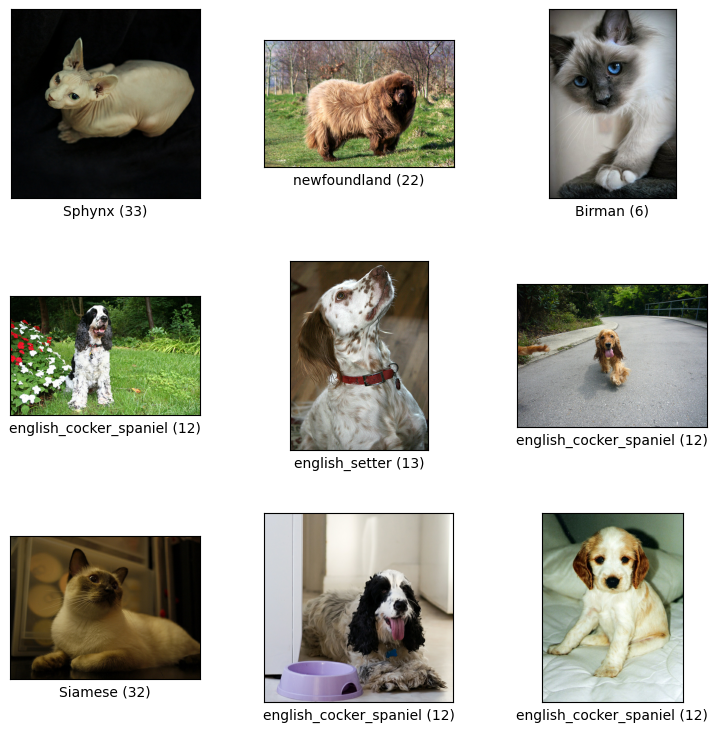

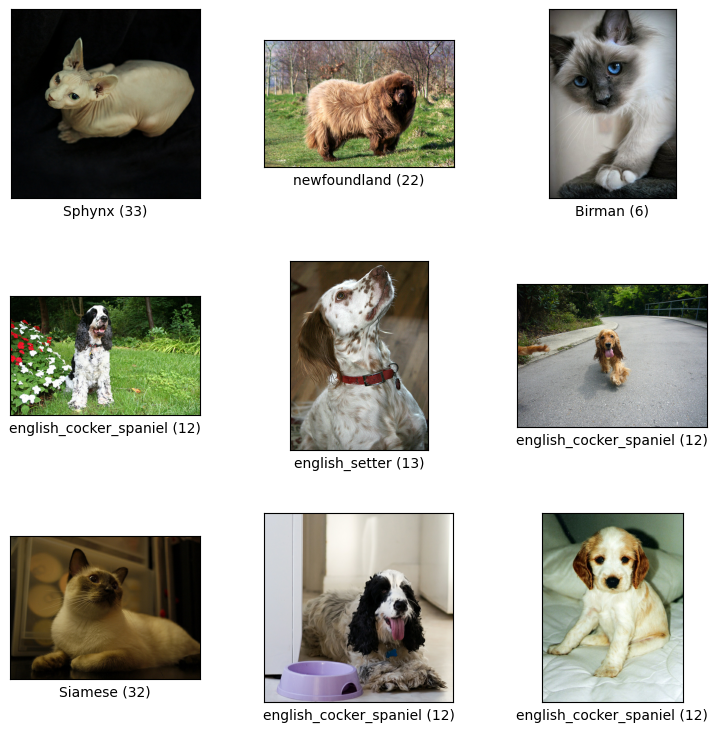

In [6]:
# Show some examples
tfds.show_examples(train_raw, ds_info, image_key='image', label_key='label', rows=3, cols=3)

In [7]:
# Show number of classes
num_classes = ds_info.features['label'].num_classes
print(f"Jumlah Class : {num_classes}")  

Jumlah Class : 37


In [8]:
# Show class names
name_classes = ds_info.features['label'].names
print(name_classes)

['Abyssinian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'Bengal', 'Birman', 'Bombay', 'boxer', 'British_Shorthair', 'chihuahua', 'Egyptian_Mau', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'Maine_Coon', 'miniature_pinscher', 'newfoundland', 'Persian', 'pomeranian', 'pug', 'Ragdoll', 'Russian_Blue', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'Siamese', 'Sphynx', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


In [9]:
label = ds_info.features['label']
species = ds_info.features['species'].names


In [87]:
for example in train_raw.take(5):
    species_label = example['species'].numpy()
    breed_label = example['label'].numpy()
    print("Name:", ds_info.features['label'].int2str(breed_label))
    print("Species:", ds_info.features['species'].int2str(species_label))
    print()
    
species_label = train_raw.map(lambda x: x['species'])
breed_label = train_raw.map(lambda x: x['label'])

Name: newfoundland
Species: Dog

Name: english_cocker_spaniel
Species: Dog

Name: Siamese
Species: Cat

Name: Bengal
Species: Cat

Name: saint_bernard
Species: Dog



In [10]:
# Show number of examples
num_train_examples = tf.data.experimental.cardinality(train_raw).numpy()
num_val_examples = tf.data.experimental.cardinality(val_raw).numpy()
num_test_examples = tf.data.experimental.cardinality(test_raw).numpy()

print(f"Jumlah Data Training: {num_train_examples}")
print(f"Jumlah Data Validation: {num_val_examples}")
print(f"Jumlah Data Testing: {num_test_examples}")

Jumlah Data Training: 3312
Jumlah Data Validation: 368
Jumlah Data Testing: 3669


In [11]:
# Get the label from the dataset
get_label_name = ds_info.features['label'].int2str

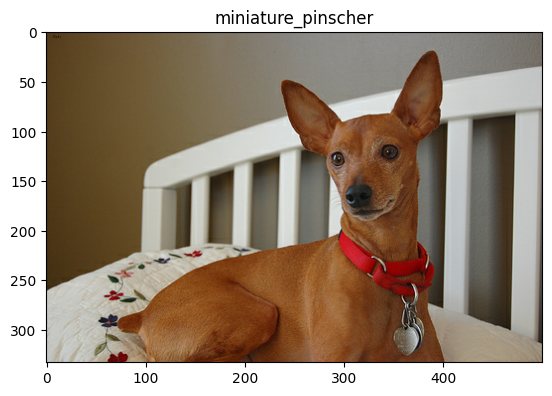

In [12]:
# Show the image and the label
def view_single_image(ds):
    image, label = next(iter(ds))
    plt.imshow(image)
    _ = plt.title(get_label_name(label))
    
    
view_single_image(train_raw)

### Data Preparation

#### Image Resizing

In [13]:
IMG_SIZE = 299

train_ds = train_raw.map(lambda x, y: (tf.image.resize(x, (IMG_SIZE, IMG_SIZE)), y))
val_ds = val_raw.map(lambda x, y: (tf.image.resize(x, (IMG_SIZE, IMG_SIZE)), y))
test_ds = test_raw.map(lambda x, y: (tf.image.resize(x, (IMG_SIZE, IMG_SIZE)), y))

#### Label one-hot encoding

In [14]:
def one_hot_encode(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

In [15]:
# map the one_hot_encode function to the train, val, and test datasets
train_ds = train_ds.map(one_hot_encode)
val_ds = val_ds.map(one_hot_encode)
test_ds = test_ds.map(one_hot_encode)

In [16]:
data_augmentation = keras.Sequential(
    [layers.RandomFlip('horizontal'), 
     layers.RandomRotation(factor=(-0.025, 0.025)),
     layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
     layers.RandomContrast(factor=0.1),
     ])

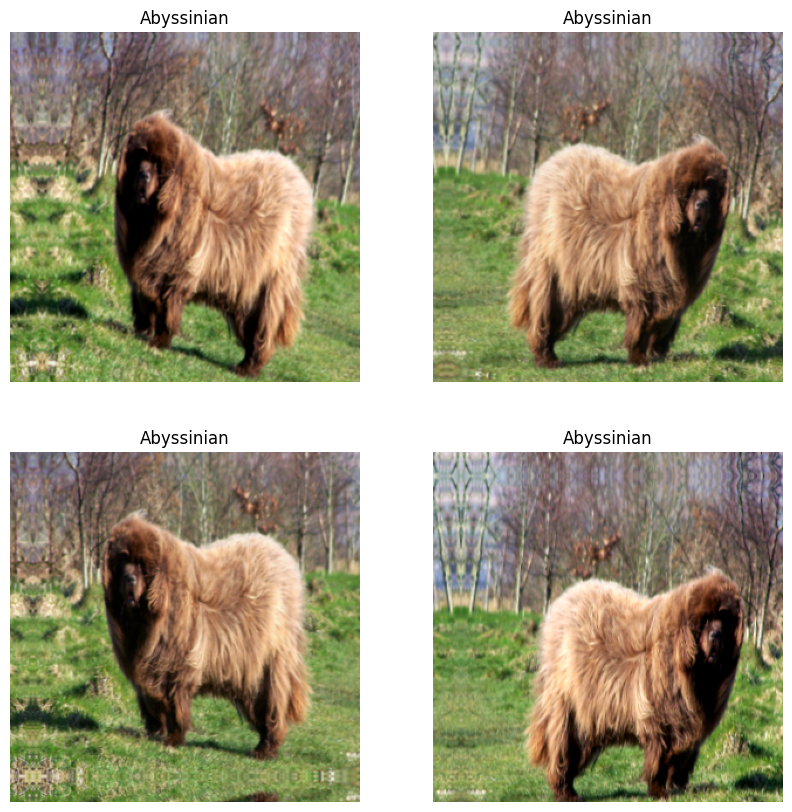

In [17]:
for image, label in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(4):
        ax = plt.subplot(2, 2, i+1)
        aug_img = data_augmentation(tf.expand_dims(image, axis=0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title(get_label_name(int(label[0])))
        plt.axis("off")

In [18]:
BATCH_SIZE = 32

In [19]:
train_ds = train_ds.batch(batch_size=BATCH_SIZE, 
                          drop_remainder=True).prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.batch(batch_size=BATCH_SIZE, 
                      drop_remainder=True).prefetch(tf.data.AUTOTUNE)
                      
test_ds = test_ds.batch(batch_size=BATCH_SIZE, 
                        drop_remainder=True).prefetch(tf.data.AUTOTUNE)

In [20]:
def getModel(dropout=0.25):
  # setup base model
  base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

  # Freeze  pre-trained weight of the base mode
  base_model.trainable = False

  # input layers
  inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
  x = data_augmentation(inputs)

  # pass inputs to a process layer
  x = tf.keras.applications.inception_v3.preprocess_input(x)
  x = base_model(x, training=False)

  # Rebuild top layers
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dropout(dropout)(x)
  x = tf.keras.layers.Dense(64, activation='relu')(x)
  outputs = tf.keras.layers.Dense(37, activation='softmax')(x)

  model = tf.keras.Model(inputs, outputs)

  # Display model summary
  model.summary()

  # Compile model
  model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=[keras.metrics.CategoricalAccuracy()])

  return model


#### Model Training

In [21]:
# prevent overfitting
earlystopping = callbacks.EarlyStopping(monitor='val_loss', 
                                        mode='min', 
                                        patience=5, 
                                        restore_best_weights=True)

In [22]:
model = getModel()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 299, 299, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 299, 299, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

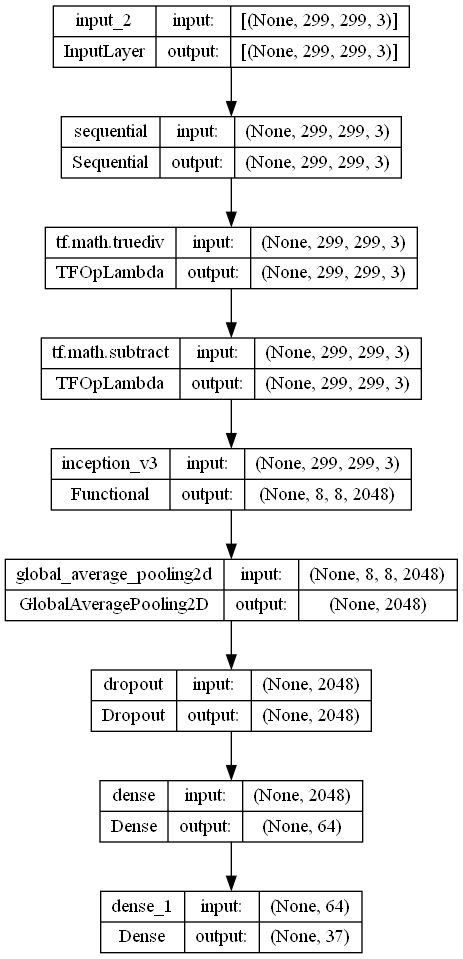

In [23]:
plot_model(model, show_shapes=True)

In [24]:
# Fit Model
history = model.fit(
    train_ds, 
    epochs = 25,
    validation_data=val_ds,
    verbose=1,
    callbacks = [earlystopping]
)

Epoch 1/25
103/103 [==============================] - 371s 4s/step - loss: 1.5854 - categorical_accuracy: 0.6302 - val_loss: 0.5170 - val_categorical_accuracy: 0.8580
Epoch 2/25
103/103 [==============================] - 291s 3s/step - loss: 0.4196 - categorical_accuracy: 0.8777 - val_loss: 0.3268 - val_categorical_accuracy: 0.9176
Epoch 3/25
103/103 [==============================] - 286s 3s/step - loss: 0.2998 - categorical_accuracy: 0.9099 - val_loss: 0.3005 - val_categorical_accuracy: 0.9148
Epoch 4/25
103/103 [==============================] - 287s 3s/step - loss: 0.2599 - categorical_accuracy: 0.9163 - val_loss: 0.2654 - val_categorical_accuracy: 0.9318
Epoch 5/25
103/103 [==============================] - 281s 3s/step - loss: 0.2044 - categorical_accuracy: 0.9360 - val_loss: 0.2445 - val_categorical_accuracy: 0.9205
Epoch 6/25
103/103 [==============================] - 283s 3s/step - loss: 0.1936 - categorical_accuracy: 0.9363 - val_loss: 0.2769 - val_categorical_accuracy: 0.903

#### Plot the accuracy of training and validation sets over epochs

Text(0.5, 1.0, 'Training and validation loss')

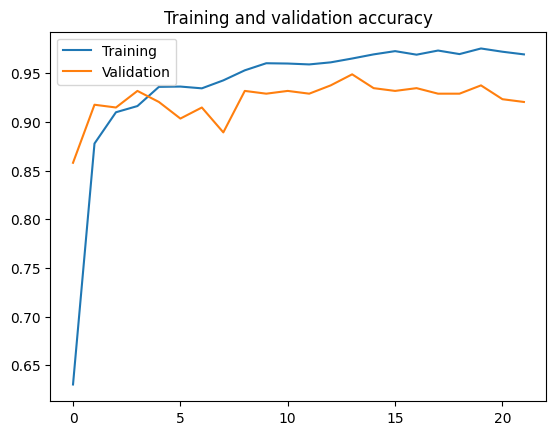

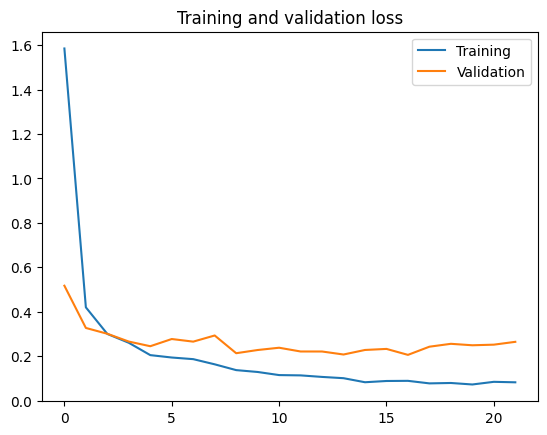

In [25]:
acc      = history.history[     'categorical_accuracy' ]
val_acc  = history.history[ 'val_categorical_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc, label='Training')
plt.plot  ( epochs, val_acc, label='Validation')
plt.title ('Training and validation accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss, label='Training')
plt.plot  ( epochs, val_loss, label='Validation')
plt.legend()
plt.title ('Training and validation loss')

### Model Evaluation

In [26]:
# Evaluate model
preds = model.predict(test_ds)

114/114 [==============================] - 255s 2s/step


In [27]:
# Evaluate model on test dataset
result = model.evaluate(test_ds)

114/114 [==============================] - 260s 2s/step - loss: 0.3369 - categorical_accuracy: 0.9019


In [28]:
# Display result
dict(zip(model.metrics_names, result))

{'loss': 0.33685246109962463, 'categorical_accuracy': 0.9018640518188477}

### Finetuned Model

In [30]:
# Unfreeze base model
for layer in model.layers[-15:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

In [29]:
# Recompile model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5), # Set a very low learning rate
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=[keras.metrics.CategoricalAccuracy()]
             )

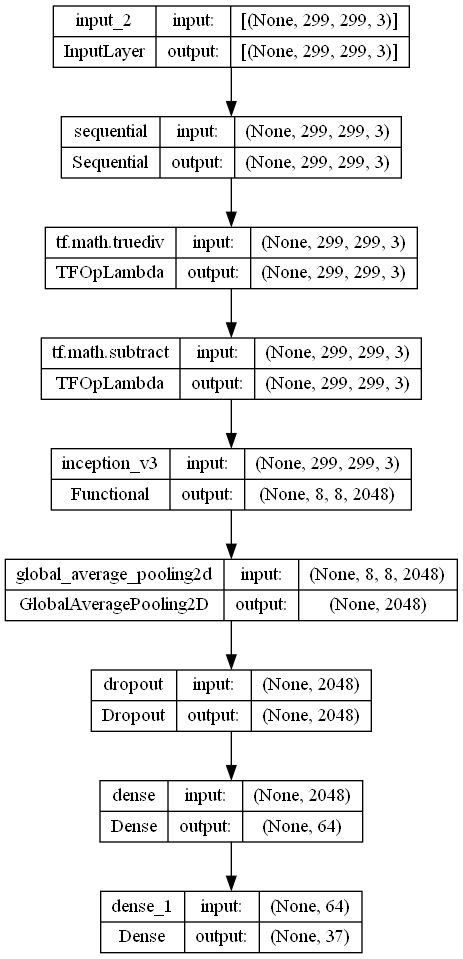

In [67]:
# visualize model
plot_model(model, show_shapes=True)

In [31]:
# Retrain model
EPOCHS = 5

history_2 = model.fit(train_ds, 
                      epochs=EPOCHS, 
                      validation_data=val_ds, 
                      verbose=1,
                      callbacks =[earlystopping])

Epoch 1/5
103/103 [==============================] - 284s 3s/step - loss: 0.0775 - categorical_accuracy: 0.9739 - val_loss: 0.1959 - val_categorical_accuracy: 0.9375
Epoch 2/5
103/103 [==============================] - 281s 3s/step - loss: 0.0609 - categorical_accuracy: 0.9779 - val_loss: 0.1929 - val_categorical_accuracy: 0.9375
Epoch 3/5
103/103 [==============================] - 279s 3s/step - loss: 0.0606 - categorical_accuracy: 0.9794 - val_loss: 0.1905 - val_categorical_accuracy: 0.9375
Epoch 4/5
103/103 [==============================] - 280s 3s/step - loss: 0.0626 - categorical_accuracy: 0.9824 - val_loss: 0.1890 - val_categorical_accuracy: 0.9403
Epoch 5/5
103/103 [==============================] - 285s 3s/step - loss: 0.0573 - categorical_accuracy: 0.9818 - val_loss: 0.1904 - val_categorical_accuracy: 0.9403


In [32]:
preds2 = model.predict(test_ds)

114/114 [==============================] - 260s 2s/step


In [33]:
# Display fine-tuned model result
result_2 = model.evaluate(test_ds)

dict(zip(model.metrics_names, result_2))

114/114 [==============================] - 256s 2s/step - loss: 0.2887 - categorical_accuracy: 0.9156


{'loss': 0.2886643707752228, 'categorical_accuracy': 0.9155701994895935}

In [34]:
# Save model
model.save('my_model.h5')

### Metrics Evaluation

In [35]:
from sklearn.metrics import classification_report, confusion_matrix

In [45]:
# Melakukan prediksi pada data validasi
y_pred = model.predict(val_ds)
y_pred = np.argmax(y_pred, axis=1)  # Mengambil indeks kelas dengan nilai probabilitas tertinggi

# Mengubah kembali one-hot encoded label menjadi label tunggal
y_true = np.concatenate([np.argmax(y, axis=1) for _, y in val_ds], axis=0)

# Membuat classification report
report = classification_report(y_true, y_pred, target_names=name_classes, output_dict=True)

11/11 [==============================] - 26s 2s/step


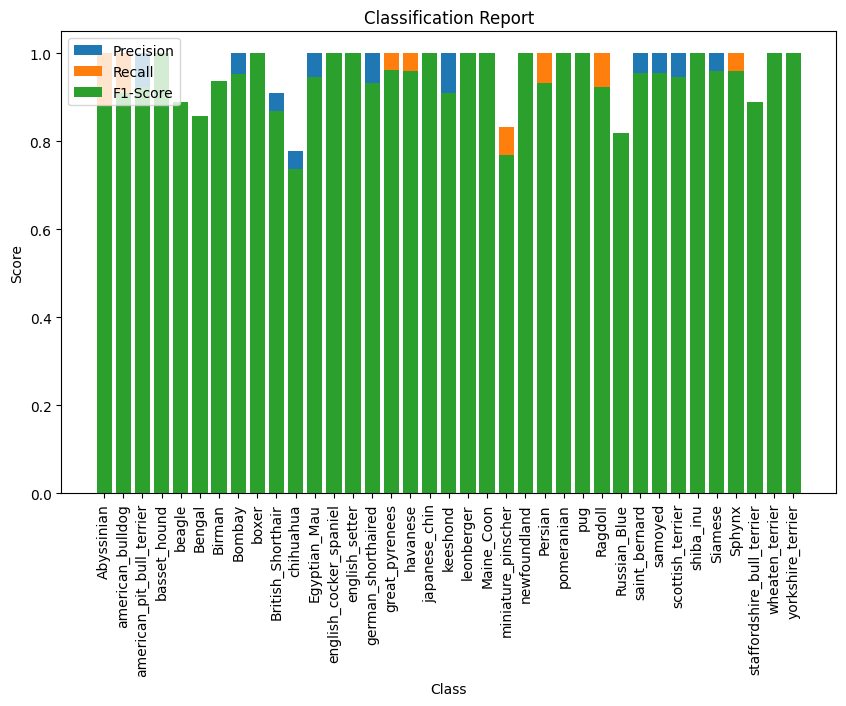

In [68]:
# Mengekstrak nilai precision, recall, dan f1-score
# Mengekstrak nilai precision, recall, dan f1-score
precision = [report[class_name]['precision'] for class_name in name_classes]
recall = [report[class_name]['recall'] for class_name in name_classes]
f1_score = [report[class_name]['f1-score'] for class_name in name_classes]


# Membuat plot
fig, ax = plt.subplots(figsize=(10, 6))
x = range(num_classes)
ax.bar(x, precision, label='Precision')
ax.bar(x, recall, label='Recall')
ax.bar(x, f1_score, label='F1-Score')
ax.set_xticks(x)
ax.set_xticklabels(name_classes, rotation=90)
ax.set_xlabel('Class')
ax.set_ylabel('Score')
ax.set_title('Classification Report')
ax.legend()
plt.show()

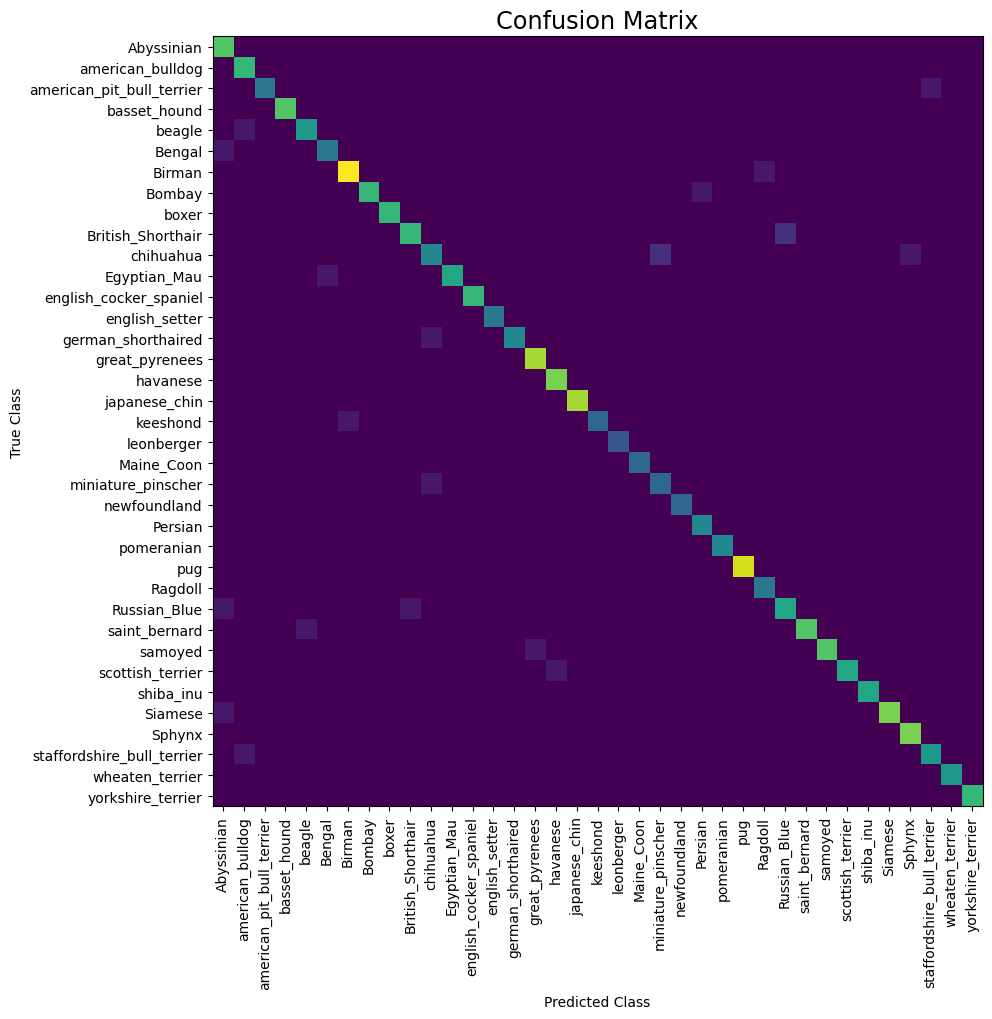

In [57]:
# Membuat confusion matrix
cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots( figsize= (10, 10))

ax.imshow(cm)

ax.set_xticks(range(0, 37))
ax.set_yticks(range(0,37))

ax.set_yticklabels(name_classes)
ax.set_xticklabels(name_classes, rotation='vertical')

plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix', size='xx-large')
plt.show()

In [59]:
import pandas as pd


# Create table for metrics evaluation
metrics = pd.DataFrame({'Class': name_classes,
                        'Precision': precision,
                        'Recall': recall,
                        'fic_score': f1_score
                        })


metrics

,Class,Precision,Recall,fic_score
0,Abyssinian,0.785714,1.000000,0.880000
1,american_bulldog,0.833333,1.000000,0.909091
2,american_pit_bull_terrier,1.000000,0.857143,0.923077
3,basset_hound,1.000000,1.000000,1.000000
4,beagle,0.888889,0.888889,0.888889
5,Bengal,0.857143,0.857143,0.857143
6,Birman,0.937500,0.937500,0.937500
7,Bombay,1.000000,0.909091,0.952381
8,boxer,1.000000,1.000000,1.000000
9,British_Shorthair,0.909091,0.833333,0.869565


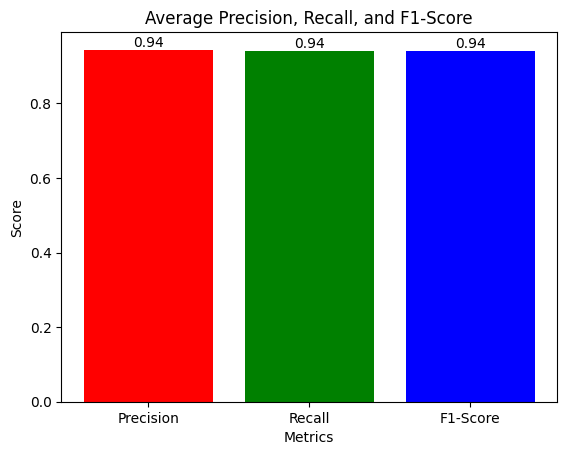

In [71]:
# visualize average precision, recall, and f1-score
# Menghitung rata-rata precision, recall, dan f1-score
avg_precision = sum(precision) / num_classes
avg_recall = sum(recall) / num_classes
avg_f1_score = sum(f1_score) / num_classes

# Menampilkan visualisasi
metrics = ['Precision', 'Recall', 'F1-Score']
values = [avg_precision, avg_recall, avg_f1_score]
colours = ['r', 'g', 'b']

plt.bar(metrics, values, color=colours)
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Average Precision, Recall, and F1-Score')

# Menambahkan nilai score pada setiap bar
for i, value in enumerate(values):
    plt.text(i, value, f'{value:.2f}', ha='center', va='bottom')
    

plt.show()

### Converted Model to TFLite

In [64]:
model = tf.keras.models.load_model('my_model.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()


# Save the TFLite model to a file
with open('OPet_model.tflite', 'wb') as f:
    f.write(tflite_model)
    
with open('labels.txt', 'w') as f:
    f.write('\n'.join(name_classes) + '\n')



INFO:tensorflow:Assets written to: C:\Users\daffa\AppData\Local\Temp\tmpn8tc9ivv\assets


INFO:tensorflow:Assets written to: C:\Users\daffa\AppData\Local\Temp\tmpn8tc9ivv\assets
